In [1]:
# manipulating dataframes
import pandas as pd

# visualizing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## load data

In [2]:
mercari = pd.read_csv('train.tsv', delimiter='\t')
mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
mercari.shape

(1482535, 8)

This is a big dataset with over a million rows, to make the analysis simpler and for demonstration purposes, I will use a subset.

In [4]:
mercari = mercari.sample(frac=0.1).reset_index(drop=True)

In [5]:
mercari.shape

(148254, 8)

## check data types

In [6]:
mercari.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## visualize numerical data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11170f240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e726710>]], dtype=object)

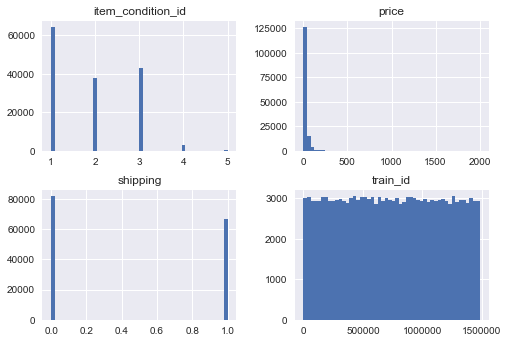

In [7]:
mercari.hist(bins = 50)

In [8]:
mercari.describe()

,train_id,item_condition_id,price,shipping
count,1.482540e+05,148254.000000,148254.000000,148254.000000
mean,7.396472e+05,1.904097,26.580298,0.448460
std,4.276826e+05,0.902072,37.700435,0.497338
min,1.100000e+01,1.000000,0.000000,0.000000
25%,3.703765e+05,1.000000,10.000000,0.000000
50%,7.382315e+05,2.000000,17.000000,0.000000
75%,1.109685e+06,3.000000,29.000000,1.000000
max,1.482533e+06,5.000000,2004.000000,1.000000


## check for missing data

In [9]:
mercari.count()

train_id             148254
name                 148254
item_condition_id    148254
category_name        147614
brand_name            84788
price                148254
shipping             148254
item_description     148252
dtype: int64

## working with the item descriptions

In [10]:
mercari.item_description[0]

'Android black USB wristband charger wrapped in light blue glow in dark survival paracord high quality brand new fast and free shipping enjoy your product!'

In [11]:
mercari.item_description[1]

'This tiny dot necklace is a beautiful piece to wear to always be a reminder of doing good onto others around you. It\'s dainty and tiny and looks great layered with other pieces. The model is wearing 17" Necklace Features: *Brass circle pendant dipped in rose gold or gold. *Circle pendant measures 4mm *Item is made to order, you choose the length and color.'

In [12]:
mercari.item_description[7]

'Holly Jolly mug set Falala spoon rest'

In [13]:
mercari.item_description[10]

'Super nice Retail [rm] Not faded at all Couple picks on front pic 3 Couple picks on sleeve pic 4 But these are not that noticeable if not for these I would label this NWOT.'

In [14]:
mercari['item_description'] = mercari.item_description.fillna('')

after looking at a few descriptions maybe the following will suffice:
1. punctuation removal (and other random symbols)
2. lowercase
3. stop word removal
4. remove digits

let's start by removing puncuation

## remove puncuation

In [15]:
from string import punctuation

In [16]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
punctuation_symbols = []
for each in list(punctuation):
    punctuation_symbols.append((each, ''))

In [18]:
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [19]:
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
    return x

In [20]:
mercari['item_description'] = mercari.item_description.apply(remove_puncuation)

## remove digits

In [21]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

In [22]:
mercari['item_description'] = mercari.item_description.apply(remove_digits)

In [23]:
mercari.item_description.head()

0    Android black USB wristband charger wrapped in...
1    This tiny dot necklace is a beautiful piece to...
2    All  items included All new and unused Ships fast
3    Colorful mandala pattern A line pleated skirt ...
4    Iron Patriot Funko Pop for sale Mint condition...
Name: item_description, dtype: object

## remove stop words

In [24]:
from nltk.corpus import stopwords

In [25]:
stop = stopwords.words('english')

In [26]:
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

In [27]:
mercari['item_description'] = mercari.item_description.apply(remove_stop_words)

In [28]:
# mercari.item_description[1482524]

still not perfect...

## make countvectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
min_df = 0.01
max_df = 0.90
ngram_range = 2 # accounting for bi-grams

In [31]:
print('feature space will include words if they appear in a minimum of ', int(min_df*len(mercari)))
print('feature space will include words if they appear in a maxiumum of ', int(max_df*len(mercari)))

feature space will include words if they appear in a minimum of  1482
feature space will include words if they appear in a maxiumum of  133428


In [32]:
# instantiate
countvec = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df, ngram_range=(0,2))

In [33]:
# fit and transform the item description
countvec_matrix = countvec.fit_transform(mercari.item_description)

In [34]:
countvec.get_feature_names()

['adjustable',
 'ask',
 'authentic',
 'available',
 'baby',
 'bag',
 'beautiful',
 'best',
 'big',
 'black',
 'blue',
 'body',
 'bought',
 'box',
 'bra',
 'brand',
 'brand new',
 'brown',
 'bundle',
 'bundle save',
 'business',
 'buy',
 'case',
 'check',
 'check listings',
 'clean',
 'closet',
 'color',
 'colors',
 'come',
 'comes',
 'comfortable',
 'comment',
 'condition',
 'cotton',
 'couple',
 'cream',
 'cute',
 'dark',
 'day',
 'days',
 'description',
 'design',
 'different',
 'dont',
 'dress',
 'easy',
 'excellent',
 'excellent condition',
 'extra',
 'fast',
 'feel',
 'feel free',
 'firm',
 'fit',
 'fits',
 'flaws',
 'free',
 'free home',
 'free shipping',
 'gently',
 'gift',
 'gold',
 'good',
 'good condition',
 'gray',
 'great',
 'great condition',
 'green',
 'grey',
 'high',
 'high quality',
 'holds',
 'home',
 'im',
 'inches',
 'included',
 'includes',
 'inside',
 'iphone',
 'item',
 'items',
 'jacket',
 'jeans',
 'know',
 'lace',
 'large',
 'leather',
 'left',
 'leggings',
 '

note: the above will produce a sparce matrix 

In [35]:
feature_matrix = pd.DataFrame(countvec_matrix.toarray(), columns=countvec.get_feature_names())
feature_matrix.head()

,adjustable,ask,authentic,available,baby,bag,beautiful,best,big,black,...,white,womens,wore,work,works,worn,worn times,xl,xs,zipper
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA to visualize

the feature space of words is pretty small..we can still take this one step further to visualize, let's apply PCA

In [36]:
from sklearn.decomposition import TruncatedSVD
import time
import numpy as np
from sklearn.preprocessing import normalize

In [37]:
tsvd = TruncatedSVD(n_components=2)

time1 = time.time()
tsvd.fit(countvec_matrix)
time2 = time.time()
print(time2-time1)

vectors = tsvd.transform(countvec_matrix)

vectors = normalize(vectors)

0.5272707939147949


In [38]:
np.sum(tsvd.explained_variance_ratio_)

0.11620105430839475

In [39]:
print(tsvd.explained_variance_ratio_)

[ 0.06586334  0.05033771]


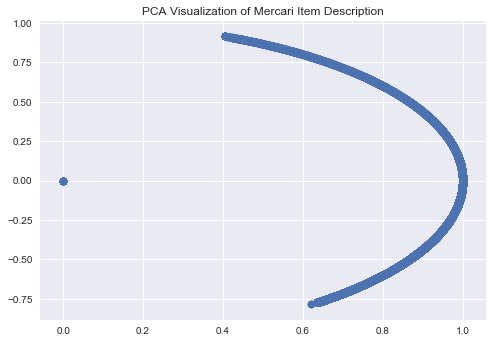

In [40]:
fig, ax = plt.subplots()
plt.scatter(vectors[:, 0], vectors[:, 1], s=50, cmap='viridis', alpha=0.4)
plt.title('PCA Visualization of Mercari Item Description')

# cluster?

In [41]:
from sklearn.cluster import KMeans

In [42]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
centroids = pd.DataFrame(kmeans.cluster_centers_)
y_kmeans = kmeans.predict(vectors)

In [43]:
mercari['cluster_affiliation'] = y_kmeans

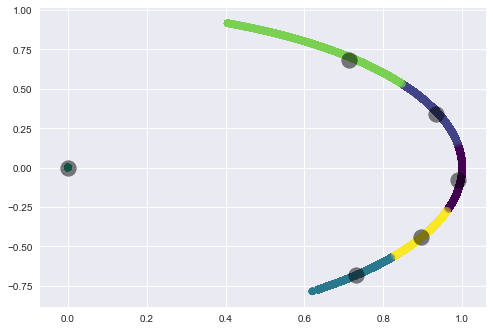

In [44]:
fig, ax = plt.subplots()
plt.scatter(vectors[:, 0], vectors[:, 1], c=y_kmeans, s=50, cmap='viridis', alpha=0.4)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=250, alpha=0.5);